<a href="https://colab.research.google.com/github/DattaAnnewsha/100-Days-of-RTL/blob/main/EE599_ML_Systems_HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW6 EE599 Systems for Machine Learning, Fall 2023
University of Southern California

Instructors: Arash Saifhashemi, Murali Annavaram

In this homework assignment, we're going to implement DP-SGD for neural networks! Recall from the class that classical ML models possessed convenient properties such as Convexity and L-Lipschitzness which make the DP analysis easy. However, modern neural networks, like the one we'll be working with, does not have these properties. Thus, we need to modify the training algorithm, gradient descent, so that the trained model is DP.

## Prerequisites:

Set the runtime type to GPU. (Runtime -> Change Runtime Type)

## Mount Google Drive

Create a folder named `HW6` under `ML_Systems` in your Google drive.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

import sys, os

data_dir = "/content/drive/MyDrive/ML_Systems/HW6/data"

Mounted at /content/drive


## Initial Setup

This section imports all required packages from PyTorch.

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import copy

torch.manual_seed(0)

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Define model architecture and prepare dataset, which are the same as the previous homework.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define the layers of the neural network architecture

        # First convolutional layer: 3 input channels, 6 output channels, kernel size 5x5
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)

        # Max pooling layer with kernel size 2x2 and stride 2
        self.pool = nn.MaxPool2d(2, 2)

        # Second convolutional layer: 6 input channels, 16 output channels, kernel size 5x5
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)

        # Fully connected (dense) layers

        # First fully connected layer: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)

        # Second fully connected layer: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84, bias=False)

        # Third fully connected layer: 84 input features, 10 output features (for classification)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through the neural network

        # Apply first convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Apply second convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))

        # The output from the convolutional and pooling layers is in the form of a
        # 3D tensor (height, width, depth or channels).
        # To feed this tensor into a fully connected layer,
        # it needs to be flattened into a 1D tensor.
        # Reshape tensor for fully connected layers
        # A2D tensor with a shape of [batch_size, 16 * 5 * 5].
        x = x.view(-1, 16 * 5 * 5)

        # Apply first fully connected layer, followed by ReLU activation
        x = F.relu(self.fc1(x))

        # Apply second fully connected layer, followed by ReLU activation
        x = F.relu(self.fc2(x))

        # Apply third fully connected layer (output layer)
        x = self.fc3(x)

        return x

In [ ]:
# A function to evaluate the performance of a given neural network model
# using a test dataset.
# It calculates the accuracy of the model's predictions on the test data.
def calculate_accuracy(
    model: nn.Module, dataloader: DataLoader, max_samples=None
) -> float:
    correct_predictions = 0  # Initialize the count of correctly predicted samples
    total_samples = 0  # Initialize the count of total samples
    inference_count = 0  # Initialize the count of inferences made

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            images, labels = batch_data  # Separate images and labels from the batch

            images = images.to(device)  # Move images to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            outputs = model(images)  # Forward pass to get model predictions
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

            total_samples += labels.size(0)  # Increment the total count of samples
            correct_predictions += (
                (predicted == labels).sum().item()
            )  # Count correct predictions

            if (
                max_samples
            ):  # Check if a maximum number of samples for testing is specified
                inference_count += images.shape[
                    0
                ]  # Increment the count of inferences made
                if (
                    inference_count > max_samples
                ):  # Stop testing if maximum samples reached
                    break

    accuracy = (
        100 * correct_predictions / total_samples
    )  # Calculate the accuracy as a percentage
    return accuracy

## DP Hyperparamters
Here is where we will defined the different hyperparameters needed for DP-SGD.
* $N = 2048$: Number of datapoints we are using. Since DP-SGD takes extremely long to run, we will only use a subset of the total CIFAR-10 dataset
* $C = 1.0$: This is the clipping threshold. If $||∇L(x, y)||_{2} > C$ then we divide by $||∇L(x, y)||_{2}$.
* $E = 20$: Number of epochs to run DP-SGD
* $q = batch\_size / N$: This is the sample probability. Since we are grouping the dataset into batches, each batch can be thought of as being sampled.
* $T = \frac{E}{q}$: number of iterations. This is more of an internal value used to calculate the DP parameter values, because DP-SGD is measured in terms of iterations, not epochs. But we can convert from Epochs to iterations.
* $\sigma$: The noise multiplier used to add noise to the gradients. As $\sigma$ gets larger, the privacy guarantee improves but the variance of the noise increases, which can reduce the accuracy or utility. The choice of $\sigma$ is often related to the desired $\varepsilon$ value; achieving a lower
$\varepsilon$ (stronger privacy) typically requires a higher
$\sigma$.

* $\delta = 10^{-5}$: This is the probability of failure. We will set this to a default value.
* $\varepsilon = \frac{q * \sqrt{T * \log(1 / \delta)}}{\sigma}$: the privacy loss, which is a function of the other hyperparameters. It quantifies the strength of the privacy guarantee. In DP, $\varepsilon$ is used to define the level of indistinguishability that the algorithm ensures between outputs generated from datasets that differ by a single element. A smaller value means  a stronger privacy guarantee, meaning the outputs of the algorithm are more similar (indistinguishable) regardless of whether any individual's data is included or excluded from the dataset.
However, a smaller value usually means more noise must be added to the data, which can degrade the utility or accuracy of the algorithm's output.


In [ ]:
batch_size = 32
N = 2048
C = 1.0
E = 20
q = batch_size / N
T = E / q
delta = 1e-5

In [ ]:
# Define the mean values and standard deviation values for normalization
mean_values = (0.5, 0.5, 0.5)  # Mean values for red, green, and blue channels
std_values = (
    0.5,
    0.5,
    0.5,
)  # Standard deviation values for red, green, and blue channels

# Define the transformation pipeline
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert images to tensors
        transforms.Normalize(mean_values, std_values),  # Normalize tensor values
    ]
)

# Load the CIFAR10 training dataset and apply the defined transformations
trainset = torchvision.datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=transform
)

trainsubset = torch.utils.data.Subset(trainset, torch.arange(N))

# Create a DataLoader to efficiently load and process training data in batches
trainloader = torch.utils.data.DataLoader(
    trainsubset, batch_size=batch_size, shuffle=False, num_workers=2
)

100%|██████████| 170498071/170498071 [00:05<00:00, 29771504.65it/s]


Extracting /content/drive/MyDrive/ML_Systems/HW6/data/cifar-10-python.tar.gz to /content/drive/MyDrive/ML_Systems/HW6/data


## Non-Private Training with SGD

In [ ]:

def SGD(model, dataloader, lr):
    # Define the loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Loop over the dataset for multiple epochs
    for epoch in range(E):
        running_loss = 0.0

        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss

        print(f"Epoch {epoch+1} loss: {running_loss/len(dataloader):.4f}")

    print("Finished Training")  # Training loop is complete

# Create model and start training
net = Net().to(device)
SGD(net, trainloader, lr=0.05)

score = calculate_accuracy(net, trainloader)
print('Accuracy of the network on the train images: {}%'.format(score))

Epoch 1 loss: 2.3020
Epoch 2 loss: 2.3006
Epoch 3 loss: 2.2974
Epoch 4 loss: 2.2823
Epoch 5 loss: 2.2019
Epoch 6 loss: 2.0951
Epoch 7 loss: 1.9962
Epoch 8 loss: 1.9137
Epoch 9 loss: 1.8426
Epoch 10 loss: 1.7804
Epoch 11 loss: 1.7222
Epoch 12 loss: 1.6700
Epoch 13 loss: 1.6180
Epoch 14 loss: 1.5727
Epoch 15 loss: 1.5318
Epoch 16 loss: 1.4884
Epoch 17 loss: 1.4438
Epoch 18 loss: 1.4009
Epoch 19 loss: 1.3529
Epoch 20 loss: 1.3044
Finished Training
Accuracy of the network on the train images: 52.587890625%


## Q1: Privacy-Aware Training with DP-SGD
TODO: Change the naive SGD function to make it become differentially private. Please refer to the original [paper](https://arxiv.org/pdf/1607.00133.pdf) for DP-SGD alogrithm.

Note that we have removed the pytorch optimizer. Instead, we'll be implementing the optimzer functionality ourselves.

We set $\sigma = 0.05$ and $lr = 0.05$. Note that this training loop has not converged to the optimal weights due to insufficient training epochs, but for simplicity, we stop training after 20 epochs. In practice, to get the optimal accuracy for DP-SGD, we need to run significantly more epochs than naive SGD.

In [ ]:
'''
from torch.nn.utils import clip_grad_norm_

def DPSGD(model, dataloader, sigma, lr):
    # Define the loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification

    # Loop over the dataset for multiple epochs
    for epoch in range(E):
        running_loss = 0.0

        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            for param in model.parameters():
                param.accumulated_grads = torch.zeros_like(param)

            # Iterate over each input sample and its corresponding label sample
            per_batch_loss = 0.0
            for input_sample, label_sample in zip(inputs, labels):
                input_sample = input_sample.unsqueeze(0)
                label_sample = label_sample.unsqueeze(0)

                # TODO: Compute gradients per sample


                # TODO: Accumulate per_sample_loss to per_batch_loss for debugging purpose


                with torch.no_grad():
                    # TODO: Clip gradients and add noise, then accumulate gradients


                # TODO: Clear gradients


            # TODO: Average per_batch_loss and accumulate it to running_loss for debug purpose


            with torch.no_grad():
                # TODO: Averge accumulated gradients and update parameters
                # Please use param.copy_() to set new param


        print(f"Epoch {epoch+1} loss: {running_loss/len(dataloader):.4f}")

    print("Finished Training")  # Training loop is complete

# Create model and start training
net = Net().to(device)
DPSGD(net, trainloader, sigma=0.05, lr=0.05)

score = calculate_accuracy(net, trainloader)
print('Accuracy of the network on the train images: {}%'.format(score))
'''

IndentationError: ignored

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
sigma = 0.05  # Noise parameter for privacy
lr = 0.05  # Learning rate
def DPSGD(model, dataloader, sigma, lr):
    # Define the loss criterion
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification

    # Loop over the dataset for multiple epochs
    for epoch in range(E):
        running_loss = 0.0

        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clear accumulated gradients
            for param in model.parameters():
                param.accumulated_grads = torch.zeros_like(param)

            # Iterate over each input sample and its corresponding label sample
            per_batch_loss = 0.0
            for input_sample, label_sample in zip(inputs, labels):
                input_sample = input_sample.unsqueeze(0)
                label_sample = label_sample.unsqueeze(0)

                # Forward pass
                outputs = model(input_sample)
                loss = criterion(outputs, label_sample)
                per_batch_loss += loss.item()

                # Compute gradients per sample
                loss.backward()

                # Clip gradients (DP-SGD specific)
                clip_grad_norm_(model.parameters(), 1.0)

                # Add noise to gradients and accumulate gradients (DP-SGD specific)
                with torch.no_grad():
                    for param in model.parameters():
                        param.accumulated_grads += param.grad + torch.randn_like(param.grad) * sigma

                # Clear gradients
                model.zero_grad()

            # Average per_batch_loss
            per_batch_loss /= len(inputs)
            running_loss += per_batch_loss

            # Average accumulated gradients and update parameters (DP-SGD specific)
            with torch.no_grad():
                for param in model.parameters():
                    param.copy_(param - lr * param.accumulated_grads / len(inputs))

        print(f"Epoch {epoch + 1} loss: {running_loss / len(dataloader):.4f}")

    print("Finished Training")

# Create model and start training
net = Net().to(device)
DPSGD(net, trainloader, sigma, lr)

score = calculate_accuracy(net, trainloader)
print('Accuracy of the network on the train images: {}%'.format(score))


Epoch 1 loss: 2.3022
Epoch 2 loss: 2.3006
Epoch 3 loss: 2.2962
Epoch 4 loss: 2.2815
Epoch 5 loss: 2.2542
Epoch 6 loss: 2.2172
Epoch 7 loss: 2.1608
Epoch 8 loss: 2.1158
Epoch 9 loss: 2.0919
Epoch 10 loss: 2.0755
Epoch 11 loss: 2.0592
Epoch 12 loss: 2.0442
Epoch 13 loss: 2.0302
Epoch 14 loss: 2.0160
Epoch 15 loss: 2.0033
Epoch 16 loss: 1.9933
Epoch 17 loss: 1.9821
Epoch 18 loss: 1.9742
Epoch 19 loss: 1.9661
Epoch 20 loss: 1.9561
Finished Training
Accuracy of the network on the train images: 30.810546875%


## Q2: Privacy and utility trade-off

TODO: Plot how $\epsilon$ changes as $\sigma$ is increasing from 0.01 to 1. For the rest of the DP-SGD hyperparameters, use the default values defined above.

In [ ]:
'''
sigma_values = np.linspace(0.01, 1, 100)
epsilon_values = []

# TODO: calculate epsilon values for each sigma value based on the formula


# Plot sigma vs epsilon
plt.plot(sigma_values, epsilon_values)
plt.xlabel("Sigma")
plt.ylabel("Epsilon")
plt.title("Sigma vs Epsilon")
plt.show()
'''

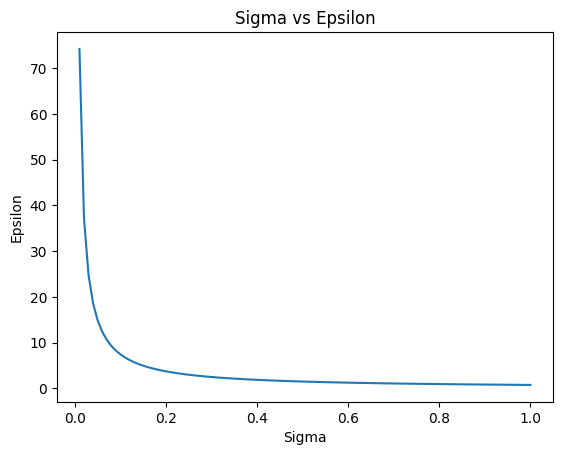

In [ ]:
sigma_values = np.linspace(0.01, 1, 100)
epsilon_values = []

epsilon = 2 * np.log(1.25 / delta) * sensitivity / (sigma * np.sqrt(N))

import numpy as np
import matplotlib.pyplot as plt

# Define privacy parameters
delta = 1e-5  # Desired privacy level (e.g., 1e-5 for 10^-5)
N = 1000  # Size of the dataset (number of samples)
sensitivity = 1  # Default sensitivity (assumed)

# Define sigma values
sigma_values = np.linspace(0.01, 1, 100)
epsilon_values = []

# Calculate epsilon values for each sigma value
for sigma in sigma_values:
    epsilon = 2 * np.log(1.25 / delta) * sensitivity / (sigma * np.sqrt(N))
    epsilon_values.append(epsilon)

# Plot sigma vs epsilon
plt.plot(sigma_values, epsilon_values)
plt.xlabel("Sigma")
plt.ylabel("Epsilon")
plt.title("Sigma vs Epsilon")
plt.show()


TODO: Run DP-SGD again with $\sigma=0.1$ and compare accuracy with the previous experiment.

In [ ]:
# Create model and start training
net = Net().to(device)
DPSGD(net, trainloader, sigma=0.1, lr=0.05)

score = calculate_accuracy(net, trainloader)
print('Accuracy of the network on the train images: {}%'.format(score))

Epoch 1 loss: 2.3013
Epoch 2 loss: 2.2960
Epoch 3 loss: 2.2813
Epoch 4 loss: 2.2573
Epoch 5 loss: 2.2225
Epoch 6 loss: 2.1828
Epoch 7 loss: 2.1486
Epoch 8 loss: 2.1226
Epoch 9 loss: 2.1086
Epoch 10 loss: 2.0958
Epoch 11 loss: 2.0845
Epoch 12 loss: 2.0771
Epoch 13 loss: 2.0750
Epoch 14 loss: 2.0664
Epoch 15 loss: 2.0585
Epoch 16 loss: 2.0526
Epoch 17 loss: 2.0461
Epoch 18 loss: 2.0432
Epoch 19 loss: 2.0392
Epoch 20 loss: 2.0369
Finished Training
Accuracy of the network on the train images: 30.6640625%


TODO:
How would privacy guarantee and model accuracy change when we increase the value of $\sigma$?

When you increase the value of `σ` (sigma) in differential privacy mechanisms like DP-SGD, several aspects related to privacy and model accuracy are affected:

1. **Privacy Guarantee**:

   - **Increased Privacy**: A larger `σ` implies increased noise added to the gradients during each training step. As a result, the privacy guarantee becomes stronger. The higher the `σ`, the more privacy is provided, as the added noise makes it harder to infer details about individual data points.

   - **Reduced Privacy Budget Consumption**: With a larger `σ`, you can achieve the same level of privacy (e.g., ε-differential privacy) while consuming less of your privacy budget. This means you can perform more iterations or have a smaller privacy budget for the same level of privacy.

2. **Model Accuracy**:

   - **Decreased Accuracy**: Increasing `σ` leads to noisier gradient updates. This noise hinders the model's ability to fit the training data accurately. As a result, the model's convergence becomes slower, and its final accuracy may be lower compared to a non-private model (or a DP-SGD model with a smaller `σ`).

   - **Trade-off**: There is a trade-off between privacy and model accuracy. When you increase `σ` for stronger privacy, you typically sacrifice some model accuracy. This trade-off can be managed by selecting an appropriate `σ` value based on your privacy requirements and the acceptable level of accuracy loss.

   Reference: Given paper and Gpt



## Q3: System cost

TODO: Why is DP-SGD computation much slower than SGD?

TODO: For the naive SGD, if there are $P$ trainable parameters, we know that we need to store $P$ gradients during each batch iteration. How many gradients need to store for DP-SGD during each batch iteration?


DP-SGD computation is typically much slower than traditional SGD (Stochastic Gradient Descent) due to the additional steps required to ensure differential privacy and the introduction of noise in the gradient updates. Here's why DP-SGD is slower:

1. **Noise Addition**: In DP-SGD, noise is added to the gradients during each batch iteration to ensure differential privacy. This noise is necessary to protect the privacy of individual data points in the training dataset. The addition of noise introduces randomness into the gradient updates, making the convergence slower.

2. **Gradients Accumulation**: In DP-SGD, instead of updating the model parameters after each sample, gradients are accumulated over a batch of samples before updating the parameters. This accumulation step is essential for accurate privacy guarantees but adds computational overhead.

3. **Clipping**: Gradients are typically clipped to limit their norm during each batch iteration in DP-SGD. This clipping step is crucial for ensuring that the noise added to the gradients does not excessively dominate the updates.

4. **Parameter Updates**: After accumulating gradients over a batch and adding noise, model parameters are updated. The noise and accumulation steps introduce additional computational complexity compared to traditional SGD.

5. **Privacy Budget Management**: To ensure differential privacy, a privacy budget must be managed across multiple iterations. This involves tracking and accounting for the cumulative privacy loss, which adds complexity and can limit the number of iterations.

Regarding the number of gradients stored during each batch iteration:

- In naive SGD, you need to store gradients for all trainable parameters during each batch iteration. If you have `P` trainable parameters, you need to store and compute `P` gradients.

- In DP-SGD, you still need to store gradients for all trainable parameters during each batch iteration. The difference is in how these gradients are used. They are accumulated over the batch of samples before being averaged and used to update the model parameters. The accumulation step introduces additional computational overhead, but the number of gradients stored remains the same, i.e., `P` gradients. However, each gradient is subject to noise and clipping as part of the DP-SGD process.

Reference: Given paper and Gpt
